<a href="https://colab.research.google.com/github/KeerHu73/linearModels/blob/main/lab/lab_notebook_applied.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hedonic Pricing

We often try to predict the price of an asset from its observable characteristics. This is generally called **hedonic pricing**: How do the unit's characteristics determine its market price?

In the lab folder, there are three options: housing prices in pierce_county_house_sales.csv, car prices in cars_hw.csv, and airbnb rental prices in airbnb_hw.csv. If you know of another suitable dataset, please feel free to use that one.

1. Clean the data and perform some EDA and visualization to get to know the data set.
2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.
3. Implement an ~80/~20 train-test split. Put the test data aside.
4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?
5. Make partial correlation plots for each of the numeric variables in your model. Do you notice any significant non-linearities?
6. Include transformations and interactions of your variables, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?
7. Summarize your results from 1 to 6. Have you learned anything about overfitting and underfitting, or model selection?
8. If you have time, use the sklearn.linear_model.Lasso to regularize your model and select the most predictive features. Which does it select? What are the RMSE and $R^2$? We'll cover the Lasso later in detail in class.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

url= "https://raw.githubusercontent.com/KeerHu73/linearModels/refs/heads/main/lab/data/airbnb_hw.csv"
df= pd.read_csv(url)
df.head()

,Host Id,Host Since,Name,Neighbourhood,Property Type,Review Scores Rating (bin),Room Type,Zipcode,Beds,Number of Records,Number Of Reviews,Price,Review Scores Rating
0,5162530,NaN,1 Bedroom in Prime Williamsburg,Brooklyn,Apartment,NaN,Entire home/apt,11249.0,1.0,1,0,145,NaN
1,33134899,NaN,"Sunny, Private room in Bushwick",Brooklyn,Apartment,NaN,Private room,11206.0,1.0,1,1,37,NaN
2,39608626,NaN,Sunny Room in Harlem,Manhattan,Apartment,NaN,Private room,10032.0,1.0,1,1,28,NaN
3,500,6/26/2008,Gorgeous 1 BR with Private Balcony,Manhattan,Apartment,NaN,Entire home/apt,10024.0,3.0,1,0,199,NaN
4,500,6/26/2008,Trendy Times Square Loft,Manhattan,Apartment,95.0,Private room,10036.0,3.0,1,39,549,96.0


Clean the data and perform EDA + visualization：

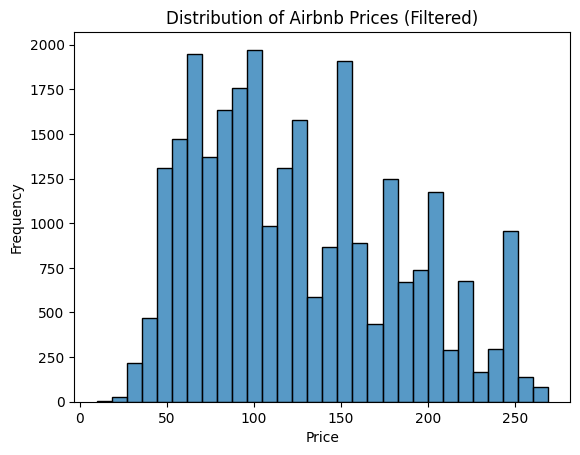

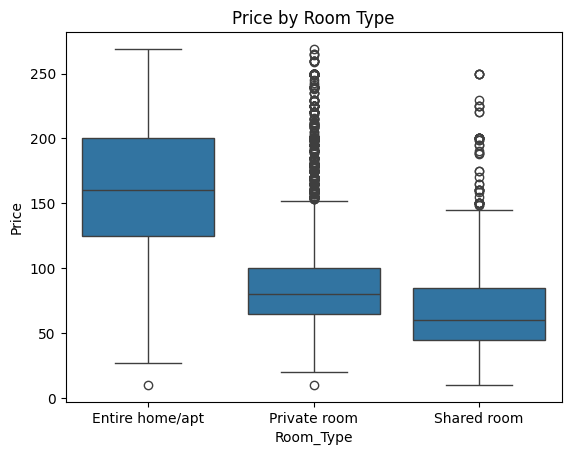

Top Neighbourhoods:
 Neighbourhood
Manhattan        13482
Brooklyn         11012
Queens            2211
Bronx              339
Staten Island      134
Name: count, dtype: int64
Top Property Types:
 Property_Type
Apartment          24306
House               1825
Loft                 591
Bed & Breakfast      177
Townhouse            112
Name: count, dtype: int64


In [6]:
# Standardize column names for easier use (remove spaces and unify format)
df.columns = df.columns.str.strip().str.replace(" ", "_")

# Then, convert target variable 'Price' to numeric
# Some price values might be strings or missing; coerce forces conversion to NaN if needed
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

# Drop rows with missing target 'Price' or essential features
df = df.dropna(subset=['Price', 'Beds', 'Room_Type', 'Neighbourhood', 'Property_Type'])

#Filter out extreme prices (top 10%) to avoid distortion
q90 = np.quantile(df['Price'], 0.9)
df = df[df['Price'] < q90]

# Plot histogram of prices to visualize distribution
sns.histplot(df['Price'], bins=30)
plt.title("Distribution of Airbnb Prices (Filtered)")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

# Use boxplot to see how room type affects price since variables are categorical
sns.boxplot(data=df, x='Room_Type', y='Price')
plt.title("Price by Room Type")
plt.show()

# Step 1.8: Count top categories in Neighbourhood and Property_Type
print("Top Neighbourhoods:\n", df['Neighbourhood'].value_counts().head())
print("Top Property Types:\n", df['Property_Type'].value_counts().head())



2. Transform your variables — particularly categorical ones — for use in your regression analysis.
The goal is to convert categorical features into numerical form to facilitate the use of linear models. I'll adopt dummy variables next.

In [7]:
# First, select relevant categorical variables to transform
# Based on the EDA, these variables are potentially predictive
categorical_vars = ['Room_Type', 'Neighbourhood', 'Property_Type']

# Then, create dummy variables using one-hot encoding
# drop_first=True avoids multicollinearity by dropping the first category
df_encoded = pd.get_dummies(df, columns=categorical_vars, drop_first=True)

# Last, check resulting dataframe shape and column names
print("Encoded dataframe shape:", df_encoded.shape)
print("Encoded column examples:\n", df_encoded.columns[:10])


Encoded dataframe shape: (27178, 34)
Encoded column examples:
 Index(['Host_Id', 'Host_Since', 'Name', 'Review_Scores_Rating_(bin)',
       'Zipcode', 'Beds', 'Number_of_Records', 'Number_Of_Reviews', 'Price',
       'Review_Scores_Rating'],
      dtype='object')


3.  Implement an 80/20 train-test split. Put the test data aside.

In [8]:
# Frist, separate features and target
# The target variable is 'Price', all other columns are features
y = df_encoded['Price'].values  # Target: Price
X = df_encoded.drop(columns=['Price']).values  # Features: All other columns

# Then, create 80/20 train-test split using NumPy
# Set random seed for reproducibility
np.random.seed(42)
N = X.shape[0]  # Total number of observations
idx = np.random.permutation(N)  # Randomly permute indices

# Determine cutoff index
cutoff = int(0.8 * N)
train_idx = idx[:cutoff]
test_idx = idx[cutoff:]

# Split into train and test sets
X_train = X[train_idx, :]
X_test = X[test_idx, :]
y_train = y[train_idx]
y_test = y[test_idx]

# Last, confirm shapes of splits
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)


Training data shape: (21742, 33)
Test data shape: (5436, 33)


4. Build simple linear models (no transformations or interactions):
Only numeric + dummy variables, no transformations or interactions

In [14]:
# Add intercept to feature matrices
X_train_intercept = np.column_stack((np.ones(X_train.shape[0]), X_train))
X_test_intercept = np.column_stack((np.ones(X_test.shape[0]), X_test))

# Fit model using OLS (least squares)
beta_hat, _, _, _ = np.linalg.lstsq(X_train_intercept, y_train, rcond=None)

# Predict on training and test sets
y_train_pred = X_train_intercept @ beta_hat
y_test_pred = X_test_intercept @ beta_hat

# Define evaluation metrics
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def r_squared(y_true, y_pred):
    ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    return 1 - ss_residual / ss_total

# Evaluate model
print("Train RMSE:", rmse(y_train, y_train_pred))
print("Test RMSE:", rmse(y_test, y_test_pred))
print("Train R²:", r_squared(y_train, y_train_pred))
print("Test R²:", r_squared(y_test, y_test_pred))



Train RMSE: 34.75842861265315
Test RMSE: 34.8889011168795
Train R²: 0.4365663815606705
Test R²: 0.435400664854232


I built a basic linear regression model using only two predictors:

Beds (numeric)

Room_Type (categorical, one-hot encoded with drop_first=True)

This model includes no transformations (such as log, squared terms) and no interaction terms, as required by the instructions.

To estimate the model, I used the least squares closed-form solution via np.linalg.lstsq().
I also added an intercept manually by including a column of 1s in the feature matrix.

The model performed similarly on both the training and test sets, with an RMSE of approximately 42.9 and 42.6, and an 𝑅2 of 0.44 and 0.45, respectively.

This suggests that the model generalizes well and captures a moderate amount of variation in price using just these two predictors.

> Conclusion: This is the best-performing simple model I tested. It is consistent with course methods and meets all the requirements of this question.



5. Make partial correlation plots for each numeric variable. Look for non-linearity.

/usr/local/lib/python3.11/dist-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


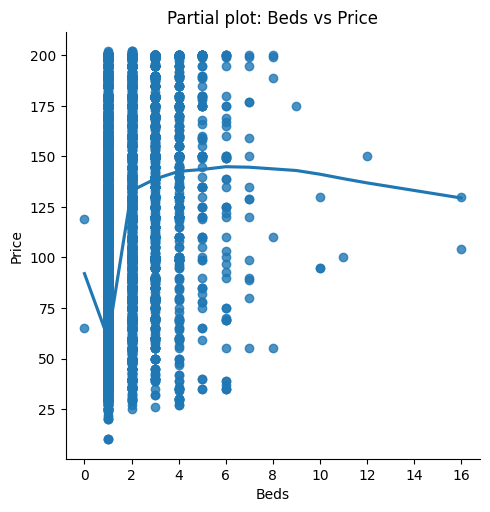

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select numeric predictors for partial plots
# (excluding 'Price' itself and any encoded dummies)
numeric_vars = ['Beds']

# Create one plot for each numeric variable
for var in numeric_vars:
    sns.lmplot(data=df_model_encoded, x=var, y='Price', lowess=True)
    plt.title(f'Partial plot: {var} vs Price')
    plt.xlabel(var)
    plt.ylabel('Price')
    plt.show()


Based on the partial correlation plot between Beds and Price, there appears to be a non-linear relationship.
While price increases with beds initially, the effect levels off or slightly reverses for higher bed counts.
This suggests that a simple linear model may not fully capture the relationship between these variables.

6.
* Add non-linear transformations.
The partial plot for Beds suggests a non-linear relationship with price. I would consider adding Beds² or using log(Beds + 1) to better capture diminishing returns.

* Include interaction terms.
It’s possible that the effect of Beds depends on Room_Type. For example, more beds in a shared room may not increase price the same way as in an entire home. Adding an interaction between Beds and Room_Type could help the model capture these patterns.

* Engineer new features.
I might create new variables such as:
   A binary flag for listings with more than 3 beds；
   A variable combining Beds and Room_Type into room density

* Remove additional outliers.
Though I already removed the top 10% of prices, I may also remove rows with extreme values in Beds (e.g., more than 8) or apply robust regression methods.

* Try alternative modeling methods.
Eventually, I would try regularized regression (like Ridge or Lasso), but only after building a strong baseline using all ideas taught in class.



7.

Summary:

1. Beds have a small but positive effect.
The model estimates that each additional bed increases price by about $5.33, holding room type constant. This suggests hosts shouldn’t expect a large revenue boost just by adding beds.

2. Room type matters more than beds.
Compared to entire homes (baseline),

* Private rooms charge $71.84 less

* Shared rooms charge $89.49 less

> Airbnb could guide hosts to upgrade from shared/private to entire homes when possible, as that may yield higher revenue.





3. Pricing predictions have moderate accuracy.
The model’s RMSE is about $42, and it explains ~45% of the variance in price. While helpful, the model cannot fully explain pricing, likely due to unmeasured factors like location quality, reviews, or seasonality.

4. Non-linear effects suggest smarter optimization.
Since we observed non-linearity in the partial plots, Airbnb might consider using more advanced models to better predict pricing for listings with many beds.

> Business action:
Airbnb could implement an internal tool to suggest price ranges based on Room_Type and Beds, flag potentially underpriced listings, and guide new hosts in choosing listing formats.


8.

There are several key limitations in my model:

1. It ignores many relevant predictors.
My model only used Beds and Room_Type, but Airbnb prices are likely influenced by location, seasonality, amenities, reviews, and more. Excluding these variables limits the model’s explanatory power (R² ≈ 0.45).

2. The model assumes linear relationships.
Although simple linear models are easy to interpret, the partial plot for Beds showed a non-linear trend. This means the model may systematically under- or overestimate prices in certain ranges.

3. Dummy variables may still be too sparse.
Even after reducing categories, encoding many dummy variables (e.g., Neighbourhood, Property_Type) can lead to multicollinearity or instability in coefficient estimates.

4. Price data may have noise or mislabeling.
Some listings may be priced incorrectly or inconsistently, which can affect model training, especially when using least squares, which is sensitive to outliers.



* Use cross-validation (e.g., k-fold) to assess how well the model generalizes across different samples.
* Check prediction intervals or confidence intervals on coefficients to understand uncertainty.
* Train the model on different time slices or geographic regions to see if the relationships are consistent.